# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            #merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
            return image, mask, 0#merged_shape
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask

C:\Users\Alqia\AppData\Local\Temp\ipykernel_23996\2698079577.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))


<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

c:\Users\Alqia\miniconda3\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


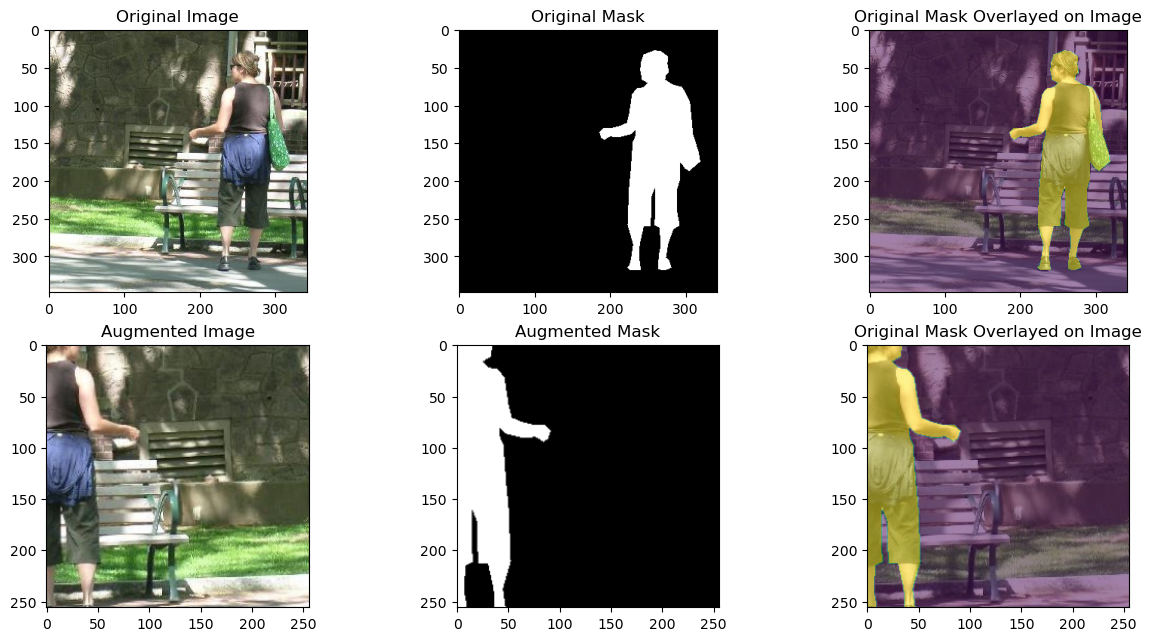

In [4]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze(), cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask.squeeze(), alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = 256

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size,scale=(0.35, 1.0), ratio=(1.0, 1.0))])
augmented_train_dataset = PennFudanDataset(
    train_image_paths, 
    train_mask_paths,
    transform=augmentation)
image, mask, _ = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze(),cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask.squeeze(), alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

test_dataset = PennFudanDataset(test_image_paths, test_mask_paths, image_size=image_size)

val_dataset = PennFudanDataset(val_image_paths, val_mask_paths, image_size=image_size)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [5]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [6]:
def dice_coefficient(output, ground_truth):
    numerical_stability = 1.
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, output, ground_truth):
        return 1 - dice_coefficient(output, ground_truth)

#### Training, Evaluation and Checkpointing Methods

[Table of Contents](#Table-of-Contents)

In [7]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, 
        filename)
    print(
            "Checkpoint saved:",
            "Epoch: {}".format(epoch),
            "Validation Loss: {:.4f}".format(val_loss),
            "Learning Rate: {:.3e}".format(optimizer.param_groups[0]["lr"]),
            sep="\t")
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(
        "Checkpoint loaded:",
        "Epoch: {}".format(epoch),
        "Validation Loss: {:.4f}".format(loss),
        "Learning Rate: {:.3e}".format(optimizer.param_groups[0]["lr"]),
        sep="\t")
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask, _ in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = (model(image))
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask, _ in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = torch.round(model(image))
            loss = criterion(pred, mask)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [8]:
NUM_EPOCHS = 100
learning_rate=0.001
batchsize=8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "./checkpoints copy"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
!del "checkpoints copy\checkpoint.pth"
criterion = SoftDiceLoss()#nn.BCELoss()#
model = UNET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True)

train_losses = []
val_losses = []
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)

In [9]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    train_losses = train_losses[:epoch]
    val_losses = val_losses[:epoch]
else:
    epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0

while epoch < NUM_EPOCHS:
    epoch += 1
    progress_bar = tqdm(
        train_loader, 
        desc="Epoch {}".format(epoch),
        ncols=85,
        unit=" batches")
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        count = 0
    else:
        count += 1
        if count == 5:
            print(
                "Training Progress:",
                "Train Loss: {:.4f}".format(train_loss),
                "Val Loss: {:.4f}".format(val_loss),
                sep="\t")
            count = 0

Epoch 1: 100%|█████████████████████████████████| 17/17 [00:06<00:00,  2.81 batches/s]


Checkpoint saved:	Epoch: 1	Validation Loss: 0.9999	Learning Rate: 1.000e-03


Epoch 2: 100%|█████████████████████████████████| 17/17 [00:03<00:00,  4.88 batches/s]


Checkpoint saved:	Epoch: 2	Validation Loss: 0.7060	Learning Rate: 1.000e-03


Epoch 3: 100%|█████████████████████████████████| 17/17 [00:03<00:00,  4.34 batches/s]


Checkpoint saved:	Epoch: 3	Validation Loss: 0.6001	Learning Rate: 1.000e-03


Epoch 4: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  4.20 batches/s]


Checkpoint saved:	Epoch: 4	Validation Loss: 0.4860	Learning Rate: 1.000e-03


Epoch 5: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  4.21 batches/s]


Checkpoint saved:	Epoch: 5	Validation Loss: 0.4818	Learning Rate: 1.000e-03


Epoch 6: 100%|█████████████████████████████████| 17/17 [00:03<00:00,  4.28 batches/s]


Checkpoint saved:	Epoch: 6	Validation Loss: 0.4420	Learning Rate: 1.000e-03


Epoch 7: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  4.11 batches/s]


Checkpoint saved:	Epoch: 7	Validation Loss: 0.4123	Learning Rate: 1.000e-03


Epoch 9: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  4.21 batches/s]


Checkpoint saved:	Epoch: 9	Validation Loss: 0.3842	Learning Rate: 1.000e-03


Epoch 14: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.28 batches/s]


Checkpoint saved:	Epoch: 14	Validation Loss: 0.3683	Learning Rate: 1.000e-03


Epoch 15: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.24 batches/s]


Checkpoint saved:	Epoch: 15	Validation Loss: 0.2935	Learning Rate: 1.000e-03


Epoch 20: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.20 batches/s]


Training Progress:	Train Loss: 0.3320	Val Loss: 0.3767


Epoch 25: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.43 batches/s]


Training Progress:	Train Loss: 0.3086	Val Loss: 0.4747


Epoch 28: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.06 batches/s]


Checkpoint saved:	Epoch: 28	Validation Loss: 0.2828	Learning Rate: 1.000e-03


Epoch 33: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.16 batches/s]


Training Progress:	Train Loss: 0.2589	Val Loss: 0.3343


Epoch 35: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.05 batches/s]


Checkpoint saved:	Epoch: 35	Validation Loss: 0.2793	Learning Rate: 1.000e-03


Epoch 40: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.02 batches/s]


Training Progress:	Train Loss: 0.2695	Val Loss: 0.3004


Epoch 41: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.16 batches/s]


Checkpoint saved:	Epoch: 41	Validation Loss: 0.2538	Learning Rate: 1.000e-03


Epoch 46: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.24 batches/s]


Training Progress:	Train Loss: 0.2300	Val Loss: 0.3174


Epoch 51: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.30 batches/s]


Training Progress:	Train Loss: 0.2552	Val Loss: 0.3049


Epoch 56: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.25 batches/s]


Checkpoint saved:	Epoch: 56	Validation Loss: 0.2214	Learning Rate: 1.000e-03


Epoch 61: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.18 batches/s]


Training Progress:	Train Loss: 0.2410	Val Loss: 0.2834


Epoch 66: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.27 batches/s]


Training Progress:	Train Loss: 0.2205	Val Loss: 0.2639


Epoch 71: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.12 batches/s]


Training Progress:	Train Loss: 0.2161	Val Loss: 0.3166


Epoch 76: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.14 batches/s]


Checkpoint saved:	Epoch: 76	Validation Loss: 0.2067	Learning Rate: 1.000e-03


Epoch 81: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.06 batches/s]


Training Progress:	Train Loss: 0.2263	Val Loss: 0.2194


Epoch 86: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.13 batches/s]


Training Progress:	Train Loss: 0.1965	Val Loss: 0.2357


Epoch 91: 100%|████████████████████████████████| 17/17 [00:03<00:00,  4.34 batches/s]


Training Progress:	Train Loss: 0.2143	Val Loss: 0.2950


Epoch 96: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.18 batches/s]


Checkpoint saved:	Epoch: 96	Validation Loss: 0.1896	Learning Rate: 1.000e-03


Epoch 100: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.30 batches/s]


In [13]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    train_losses = train_losses[:epoch]
    val_losses = val_losses[:epoch]
else:
    epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0
while optimizer.param_groups[0]['lr'] > 1e-7 and val_loss > 0.1:
    epoch += 1
    progress_bar = tqdm(
        train_loader, 
        desc="Epoch {}".format(epoch),
        ncols=85,
        unit=" batches")
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        count = 0
    else:
        count += 1
        if count == 5:
            print(
                "Training Progress:",
                "Epoch: {}".format(epoch),
                "Train Loss: {:.4f}".format(train_loss),
                "Val Loss: {:.4f}".format(val_loss),
                "Learning Rate = {:.1e}".format(optimizer.param_groups[0]["lr"]),
                sep="\t")
            count = 0

Checkpoint loaded:	Epoch: 154	Validation Loss: 0.1755	Learning Rate: 1.000e-04


Epoch 159: 100%|███████████████████████████████| 17/17 [00:04<00:00,  4.04 batches/s]


Training Progress:	Epoch: 159	Train Loss: 0.1500	Val Loss: 0.1847	Learning Rate = 1.0e-04


Epoch 164: 100%|███████████████████████████████| 17/17 [00:04<00:00,  4.21 batches/s]


Training Progress:	Epoch: 164	Train Loss: 0.1497	Val Loss: 0.1805	Learning Rate = 1.0e-04


Epoch 165: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.77 batches/s]


Epoch 00436: reducing learning rate of group 0 to 1.0000e-05.


Epoch 169: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.40 batches/s]


Training Progress:	Epoch: 169	Train Loss: 0.1491	Val Loss: 0.1860	Learning Rate = 1.0e-05


Epoch 174: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.67 batches/s]


Training Progress:	Epoch: 174	Train Loss: 0.1415	Val Loss: 0.1816	Learning Rate = 1.0e-05


Epoch 179: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.92 batches/s]


Training Progress:	Epoch: 179	Train Loss: 0.1427	Val Loss: 0.1871	Learning Rate = 1.0e-05


Epoch 184: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.62 batches/s]


Training Progress:	Epoch: 184	Train Loss: 0.1494	Val Loss: 0.1862	Learning Rate = 1.0e-05


Epoch 186: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.34 batches/s]


Epoch 00457: reducing learning rate of group 0 to 1.0000e-06.


Epoch 189: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.31 batches/s]


Training Progress:	Epoch: 189	Train Loss: 0.1493	Val Loss: 0.1854	Learning Rate = 1.0e-06


Epoch 194: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.30 batches/s]


Training Progress:	Epoch: 194	Train Loss: 0.1486	Val Loss: 0.1835	Learning Rate = 1.0e-06


Epoch 199: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.31 batches/s]


Training Progress:	Epoch: 199	Train Loss: 0.1523	Val Loss: 0.1830	Learning Rate = 1.0e-06


Epoch 204: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.94 batches/s]


Training Progress:	Epoch: 204	Train Loss: 0.1479	Val Loss: 0.1841	Learning Rate = 1.0e-06


Epoch 207: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.38 batches/s]


Epoch 00478: reducing learning rate of group 0 to 1.0000e-07.


Epoch 209: 100%|███████████████████████████████| 17/17 [00:04<00:00,  4.02 batches/s]


Training Progress:	Epoch: 209	Train Loss: 0.1456	Val Loss: 0.1844	Learning Rate = 1.0e-07


Epoch 214: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.77 batches/s]


Training Progress:	Epoch: 214	Train Loss: 0.1586	Val Loss: 0.1844	Learning Rate = 1.0e-07


Epoch 219: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.65 batches/s]


Training Progress:	Epoch: 219	Train Loss: 0.1444	Val Loss: 0.1841	Learning Rate = 1.0e-07


Epoch 224: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.48 batches/s]


Training Progress:	Epoch: 224	Train Loss: 0.1435	Val Loss: 0.1838	Learning Rate = 1.0e-07


Epoch 228: 100%|███████████████████████████████| 17/17 [00:03<00:00,  4.69 batches/s]


Epoch 00499: reducing learning rate of group 0 to 1.0000e-08.


Checkpoint loaded:	Epoch: 154	Validation Loss: 0.1755	Learning Rate: 1.000e-04


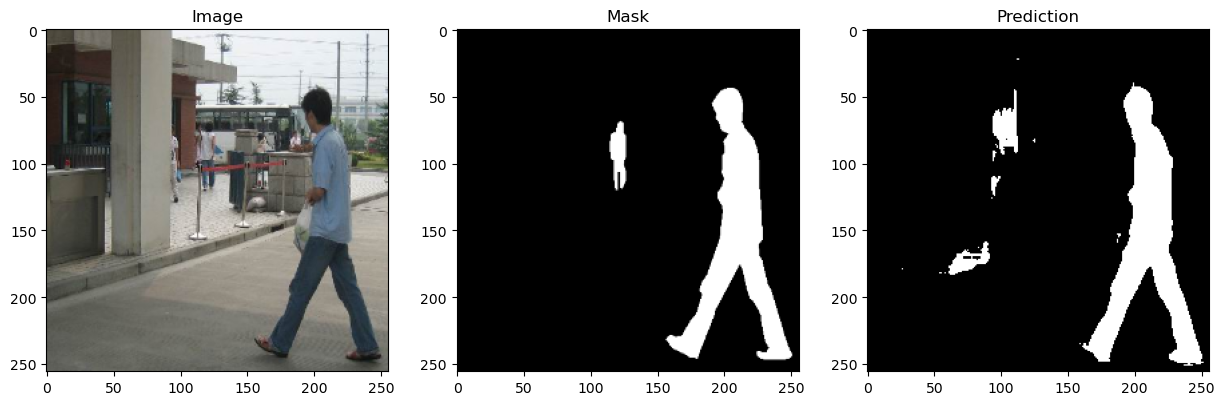

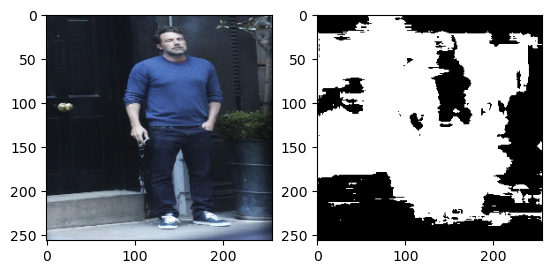

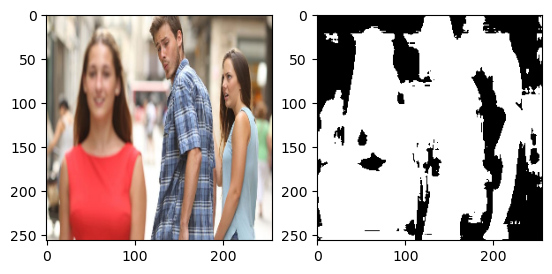

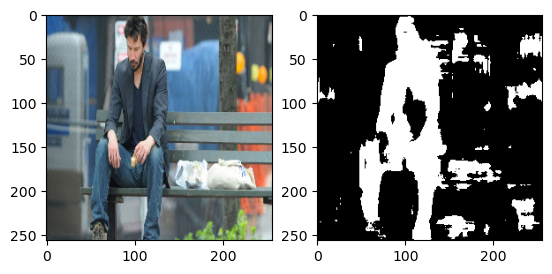

In [14]:
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)

# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask, _ = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = torch.round(model(image))
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[3].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[3].squeeze(), cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[3].squeeze(), cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()
    

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image, shape = square_pad(image)
        image = cv2.resize(image, (image_size, image_size))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = torch.round(pred)
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [15]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README2.md

[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 3790890 bytes to aaz7118-CA04.html
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README2_files\
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Making directory README2_files
[NbConvertApp] Writing 39764 bytes to README2.md
